In [29]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [219]:
# 필요한 변수 생성
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [11]:
# 데이터 불러오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [12]:
# val 개수가 적어 train과 val 데이터를 합쳐 8:2로 분할
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [13]:
# 정상 이미지와 폐렴 이미지 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [14]:
# 정상 이미지와 폐렴 이미지 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [15]:
# train 데이터와 val 데이터 변수에 저장
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [16]:
# train 데이터, val 데이터 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [17]:
# 파일 경로에 있는 NORMAL과 PNEUMONIA 으로 라벨 데이터 생성
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [18]:
# 이미지를 float으로 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE) 
    return img

def process_path(file_path):
    label = get_label(file_path) 
    img = tf.io.read_file(file_path) 
    img = decode_img(img)
    return img, label

In [19]:
# train 데이터와 val 데이터 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
# 이미지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [21]:
# test 데이터 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [22]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

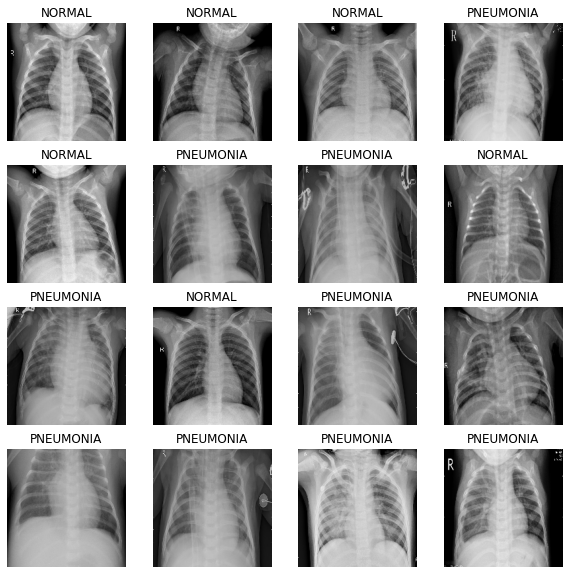

In [23]:
# 데이터 시각화
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [24]:
# conv block 함수
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [25]:
# dense block 함수
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [26]:
# 모델 생성
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [27]:
# 가중치 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [28]:
# 모델 훈련
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 199ms/step - loss: 0.3893 - accuracy: 0.8221 - precision: 0.9553 - recall: 0.7983 - val_loss: 0.7504 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 196ms/step - loss: 0.2400 - accuracy: 0.9076 - precision: 0.9706 - recall: 0.9032 - val_loss: 1.4158 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 198ms/step - loss: 0.1943 - accuracy: 0.9265 - precision: 0.9775 - recall: 0.9225 - val_loss: 0.4149 - val_accuracy: 0.7971 - val_precision: 0.7834 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 199ms/step - loss: 0.1686 - accuracy: 0.9370 - precision: 0.9807 - recall: 0.9337 - val_loss: 0.0810 - val_accuracy: 0.9644 - val_precision: 0.9739 - val_recall: 0.9777
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1686 - accura

39/39 [==============================] - 4s 108ms/step - loss: 0.5959 - accuracy: 0.8173 - precision: 0.7805 - recall: 0.9846
Loss: 0.5958888530731201,
Accuracy: 0.817307710647583,
Precision: 0.7804877758026123,
Recall: 0.9846153855323792


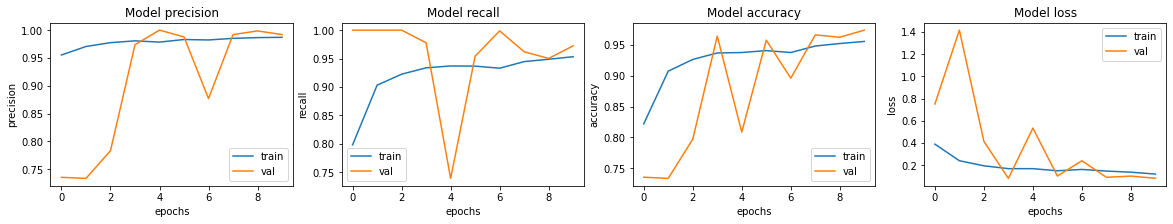

In [29]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [256]:
# 데이터 불러오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [257]:
# val 개수가 적어 train과 val 데이터를 합쳐 8:2로 분할
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [258]:
# 정상 이미지와 폐렴 이미지 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [259]:
# 정상 이미지와 폐렴 이미지 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [260]:
# train 데이터와 val 데이터 변수에 저장
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [261]:
# train 데이터, val 데이터 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [262]:
# 파일 경로에 있는 NORMAL과 PNEUMONIA 으로 라벨 데이터 생성
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # "PNEUMONIA"면 1, 그렇지 않으면 0 반환
    return tf.where(parts[-2] == "PNEUMONIA", 1, 0)

In [263]:
# 이미지를 float으로 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE) 
    return img

def process_path(file_path):
    label = get_label(file_path)  # 정수 형태로 레이블을 반환해야 함
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [264]:
# train 데이터와 val 데이터 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [265]:
# 이미지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [266]:
# test 데이터 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [267]:
# 기존 데이터 변형
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000, repeat=True):
    ds = ds.map(
        augment,
        num_parallel_calls=AUTOTUNE
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    if repeat:
        ds = ds.repeat()  # 훈련 데이터에만 repeat 적용
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds, repeat=True)
val_ds = prepare_for_training(val_ds, repeat=False)

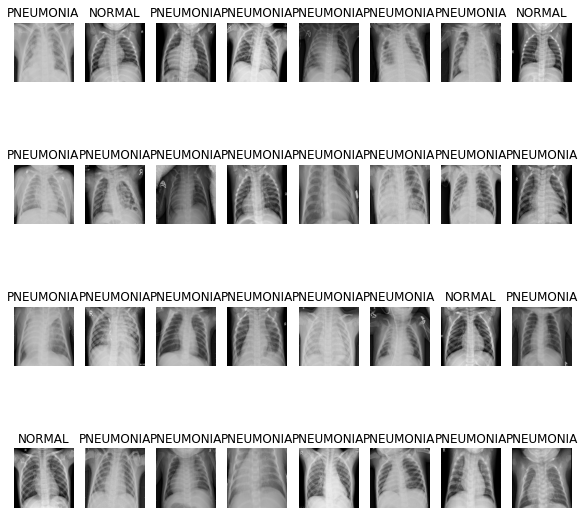

In [268]:
# 데이터 시각화
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [269]:
# Residual block
from tensorflow.keras.layers import Layer, Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size=3, stride=1, use_conv_shortcut=False):
        super(ResidualBlock, self).__init__()
        self.use_conv_shortcut = use_conv_shortcut
        self.stride = stride
        self.filters = filters

        # Main path
        self.conv1 = Conv2D(filters, kernel_size, strides=stride, padding="same", use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()

        self.conv2 = Conv2D(filters, kernel_size, strides=1, padding="same", use_bias=False)
        self.bn2 = BatchNormalization()

        # Shortcut path, if necessary
        if self.use_conv_shortcut or self.stride != 1:
            self.conv_shortcut = Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)
            self.bn_shortcut = BatchNormalization()

    def call(self, inputs, training=False):
        x = inputs

        # Main path
        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)

        # Shortcut path
        if self.use_conv_shortcut or self.stride != 1:
            x = self.conv_shortcut(x)
            x = self.bn_shortcut(x, training=training)

        # Adding up the main and shortcut paths
        out = Add()([x, out])
        out = ReLU()(out)
        return out

In [270]:
# resnet 구현
def ResNet18(input_shape=(180, 180, 3), classes=2):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(3, strides=2, padding="same")(x)

    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)

    x = ResidualBlock(128, stride=2, use_conv_shortcut=True)(x)
    x = ResidualBlock(128)(x)

    x = ResidualBlock(256, stride=2, use_conv_shortcut=True)(x)
    x = ResidualBlock(256)(x)

    x = ResidualBlock(512, stride=2, use_conv_shortcut=True)(x)
    x = ResidualBlock(512)(x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # 변경된 부분

    model = Model(inputs, outputs)
    return model

# 모델 생성
model = ResNet18()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 64)        9408      
_________________________________________________________________
batch_normalization_12 (Batc (None, 90, 90, 64)        256       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
residual_block_4 (ResidualBl (None, 45, 45, 64)        74240     
_________________________________________________________________
residual_block_5 (ResidualBl (None, 45, 45, 64)        7424

In [271]:
# 모델 컴파일
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

K.clear_session()
model = ResNet18()
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [272]:
# recall을 강조하기 위한 가중치 조절
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0  # 폐렴에 더 높은 가중치

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [273]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/10
130/130 [==============================] - 55s 338ms/step - loss: 0.1882 - accuracy: 0.9269 - precision: 0.9735 - recall: 0.9270 - val_loss: 1.4528 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 43s 330ms/step - loss: 0.1163 - accuracy: 0.9577 - precision: 0.9825 - recall: 0.9602 - val_loss: 2.7516 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 43s 336ms/step - loss: 0.0706 - accuracy: 0.9736 - precision: 0.9927 - recall: 0.9716 - val_loss: 2.6052 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 43s 335ms/step - loss: 0.0576 - accuracy: 0.9815 - precision: 0.9935 - recall: 0.9816 - val_loss: 2.5387 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 45s 346ms/step - loss: 0.0473 - accura

20/20 [==============================] - 5s 230ms/step - loss: 0.5719 - accuracy: 0.8510 - precision: 0.8430 - recall: 0.9359
Loss: 0.5719025135040283,
Accuracy: 0.8509615659713745,
Precision: 0.8429561257362366,
Recall: 0.9358974099159241


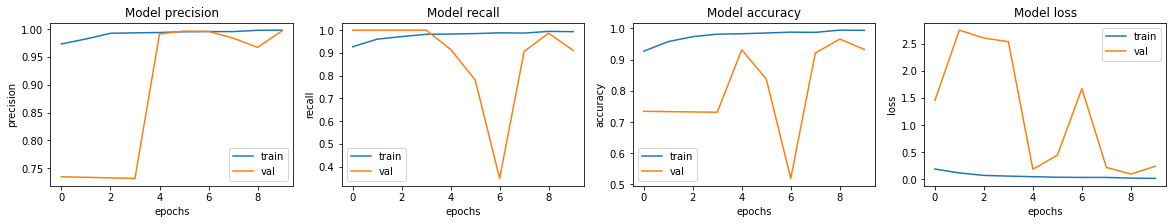

In [274]:
# 결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')